# QC + Doublet Finder

Basic QC. Find doublets per sample, visualize on overall UMAP and mark them.

In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)
library(DoubletFinder)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

In [3]:
day_config = read.table("../../figures_factory/configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

day  colour 
D0   D0   #A61C24
D2   D2   #FF70A6
D4   D4   #D6E82F
D6   D6   #B14AED
D8   D8   #2D3142
D10  D10  #FC7753
D12  D12  #0AABB7
D14  D14  #336699
iPSC iPSC #000000

## Load Data

In [4]:
# aggregated cellranger data
rna.data = Read10X("/srv/scratch/surag/scRNA-reprog/aggregate/filtered_feature_bc_matrix")

In [5]:
rna = CreateSeuratObject(counts = rna.data, project = "scRNA-reprog", min.cells = 3, min.features = 200)

In [6]:
rna

An object of class Seurat 
29165 features across 86089 samples within 1 assay 
Active assay: RNA (29165 features, 0 variable features)

In [7]:
median(Matrix::colSums(rna@assays$RNA@counts))

[1] 12514

In [8]:
rownames(rna)[grep("lnc", rownames(rna), ignore.case = T)]

[1] "LNCTAM34A" "ERLNC1"    "THORLNC"   "LNCSRLR"   "LNCPRESS2" "FILNC1"   
 [7] "LNCPRESS1" "FLNC"      "LNCOC1"    "LNCARSR"   "LNCAROD"   "LNCOG"    
[13] "ARLNC1"

In [9]:
rna[["sample"]] = DAYS[as.numeric(lapply(strsplit(colnames(rna), "-"), "[[", 2))]

In [11]:
head(rna@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample
AAACCCAAGAGTGACC-1 scRNA-reprog 13707      3472         D0    
AAACCCAAGTGCCAGA-1 scRNA-reprog 12326      3497         D0    
AAACCCACAACTCGAT-1 scRNA-reprog 22321      4690         D0    
AAACCCACACCATTCC-1 scRNA-reprog 14442      3996         D0    
AAACCCACACGACAGA-1 scRNA-reprog 33141      5709         D0    
AAACCCACACGCGTCA-1 scRNA-reprog  8813      2793         D0

In [12]:
ncol(rna)

[1] 86089

In [13]:
table(rna@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8  iPSC 
11658 13297  9635 10172  3925  7298 11078  7802 11224 

## Process

### QC Filters

In [14]:
rna[["percent.mt"]] = PercentageFeatureSet(rna, pattern="^MT-")
rna[["percent.oskm"]] = PercentageFeatureSet(rna, pattern="^(POU5F1|KLF4|MYC|SOX2)$")

In [15]:
quantile(rna@meta.data$nFeature_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%      10%      25%      50%      90%      99%     100% 
  200.00   823.00  2326.00  3450.00  5747.00  8029.12 11640.00

In [27]:
quantile(rna@meta.data$nCount_RNA, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%      10%      25%      50%      90%      99%     100% 
   500.0   3768.0   8290.0  13562.0  34534.0  77202.5 320023.0

In [17]:
quantile(rna@meta.data$percent.mt, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%       10%       25%       50%       90%       99%      100% 
 0.000000  3.634015  5.029863  6.703168 20.417217 87.160872 96.802800

In [18]:
quantile(rna@meta.data$percent.oskm, c(0, 0.1, 0.25, 0.5, 0.9, .99, 1))

0%         10%         25%         50%         90%         99% 
 0.00000000  0.00000000  0.02145923  0.13426423  0.45042937  4.74596945 
       100% 
96.08176174

In [32]:
quantile(rna@meta.data$percent.oskm[rna$sample=="D2"], c(0, 0.1, 0.25, 0.5, 0.9, .95, .99, 1))

0%         10%         25%         50%         90%         95% 
 0.00000000  0.09059388  0.19841270  0.50989244 12.36673799 44.56426561 
        99%        100% 
90.27360031 95.41721557

In [193]:
qc_plot <- function(df, xlab, ylab, xline, yline, base_size=18) {
    ggplot(df, aes(x=x,y=y)) +
    stat_binhex(aes(fill=log10(1+..count..)), bins=100) +
    scale_fill_viridis_c() +
    xlab(xlab) + ylab(ylab) +
    geom_vline(xintercept = xline, col='red') + 
    geom_hline(yintercept = yline, col='red') +
    theme_bw(base_size=base_size)
}

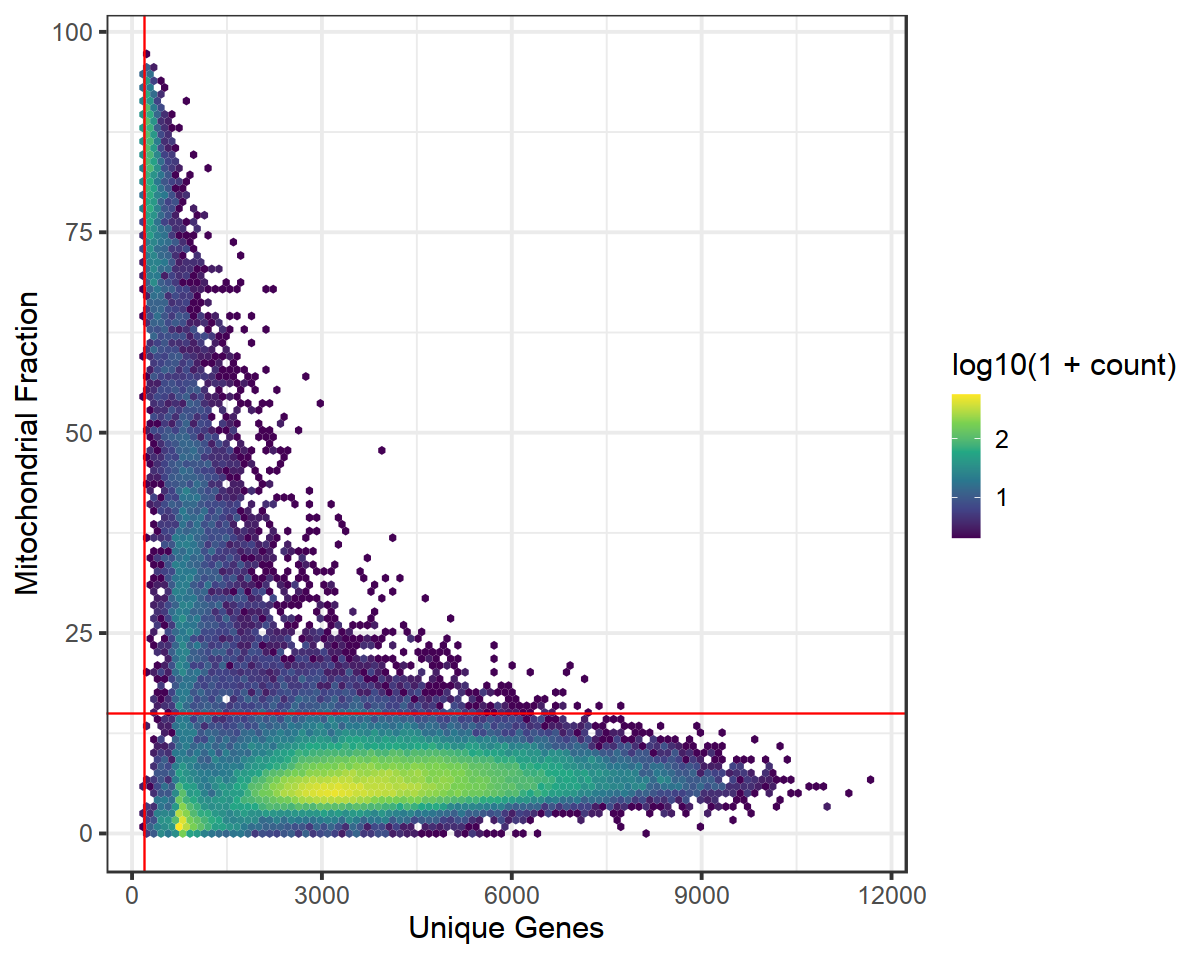

In [79]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(
    x=rna@meta.data$nFeature_RNA,
    y=rna@meta.data$percent.mt), 
        "Unique Genes", 
        "Mitochondrial Fraction",
       200, 15)

In [206]:
mt_vs_log_ct[[10]]

ERROR: Error in mt_vs_log_ct[[10]]: subscript out of bounds


In [211]:
mt_vs_log_ct[[i]] = cowplot::get_legend(mt_vs_log_ct[[i-1]] + theme(legend.position="top") )

In [239]:
mt_vs_log_ct = list()

i=1
for (x in DAYS) {
   mt_vs_log_ct[[i]] = qc_plot(data.frame(
       x=log10(rna$nCount_RNA[rna$sample==x]),
       y=rna$percent.mt[rna$sample==x]), 
       "Log Counts", 
       "Mitochondrial Fraction",
       log10(2000), 15,
                               base_size=24) + 
    ggtitle(x) +
    xlim(c(2.5,5.5)) +
    ylim(c(-1,101)) +
    theme(plot.title = element_text(hjust = 0.5, size=28),
         legend.position = "none")
    
    i = i + 1
}

mt_vs_log_ct[[i]] = cowplot::get_legend(mt_vs_log_ct[[i-1]] + 
                                        theme(legend.position="right", 
                                              legend.key.width = unit(2, "cm"),
                                             legend.key.height = unit(1, "cm")) +
                                       scale_fill_viridis_c(name="Log Density",
                                                            labels=c()))

all_mt_vs_log_ct = wrap_plots(mt_vs_log_ct, nrow = 2)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”


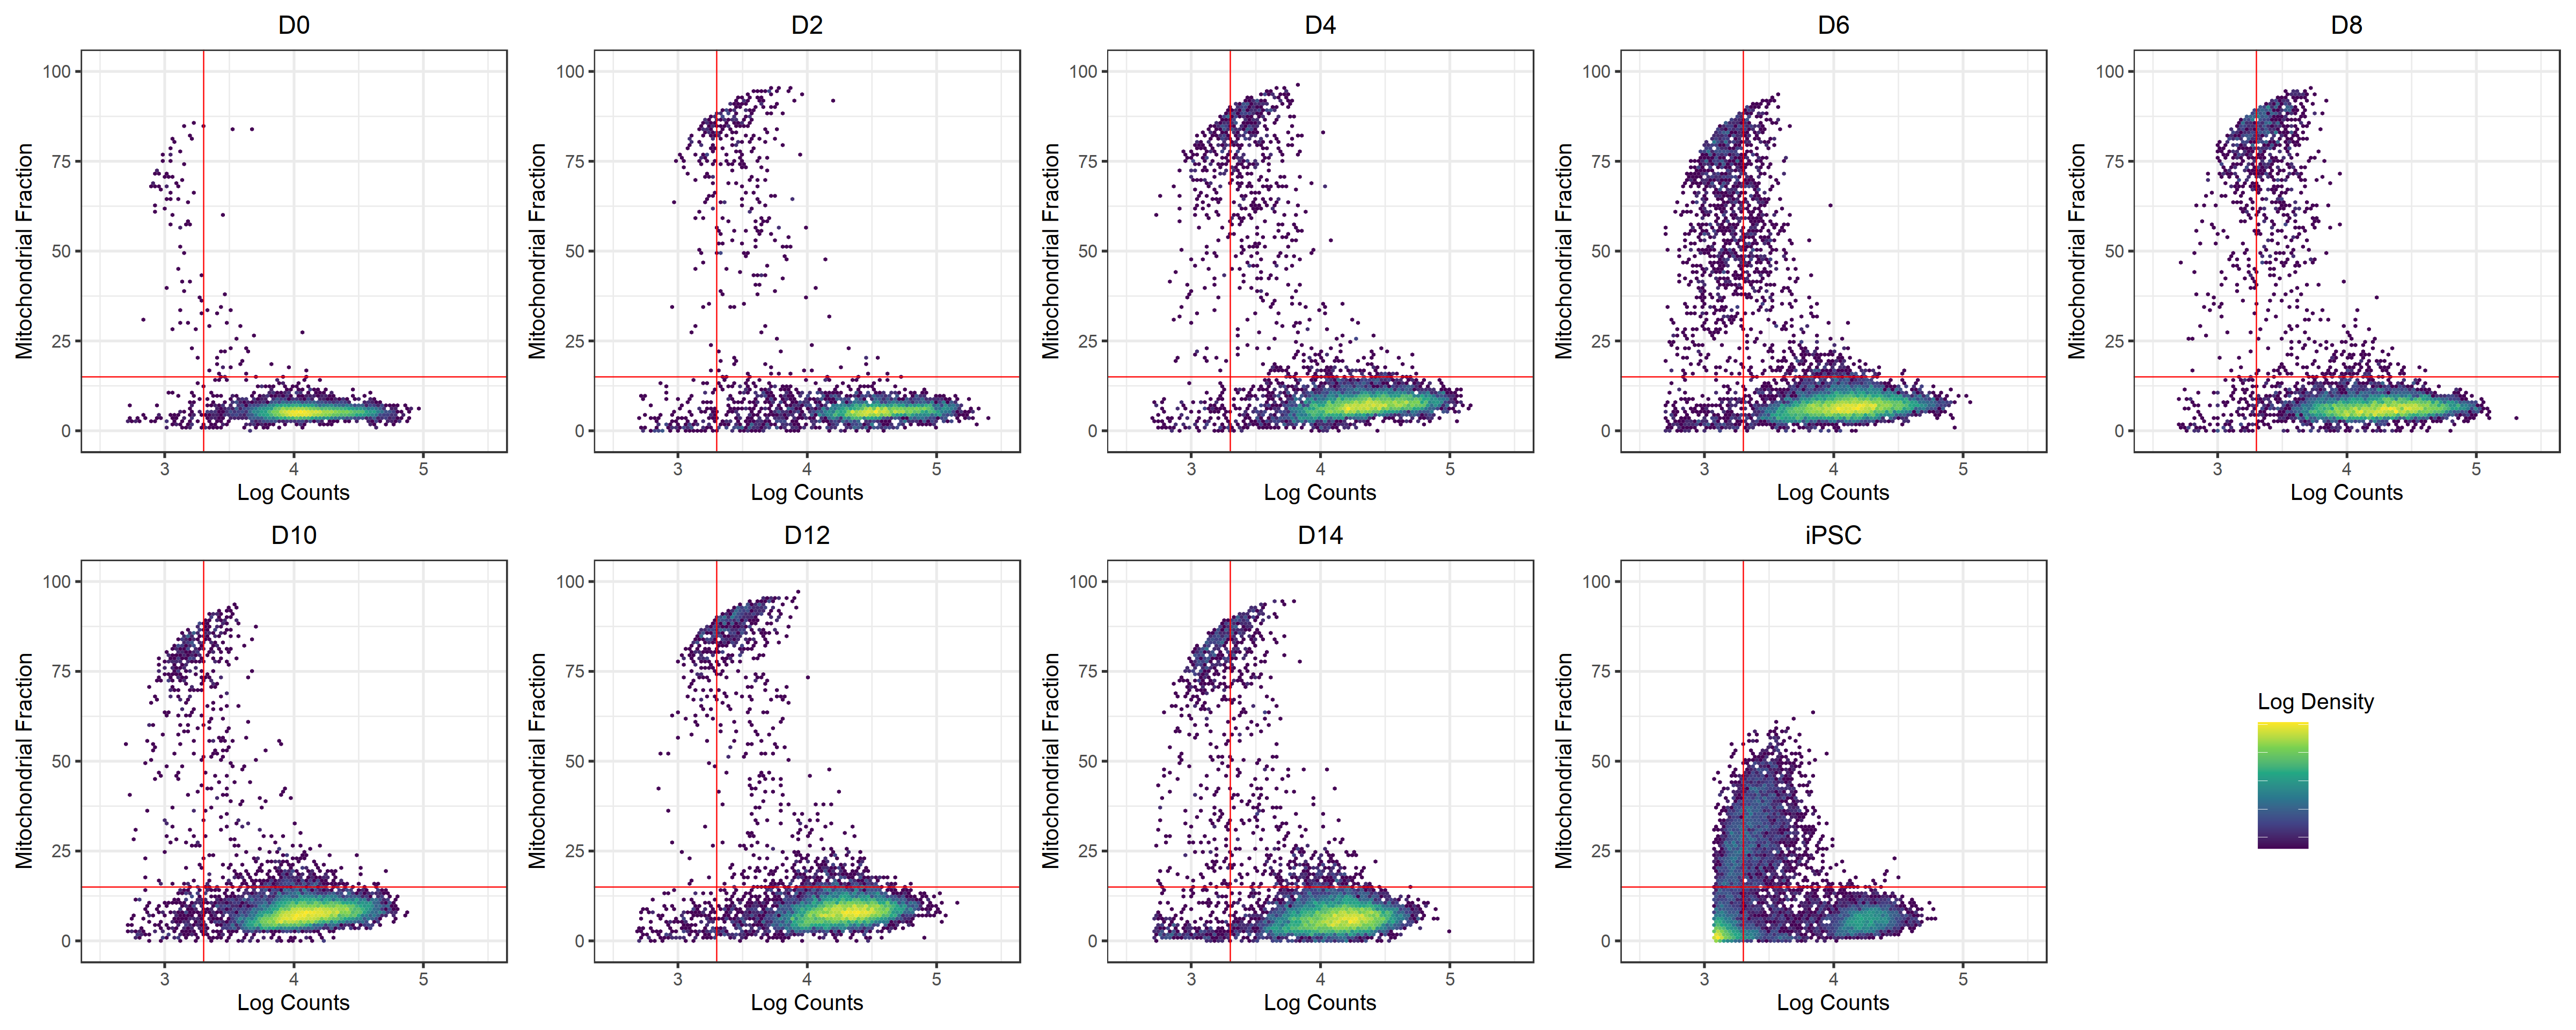

In [242]:
options(repr.plot.width = 40, repr.plot.height = 16)
all_mt_vs_log_ct

In [243]:
ggsave("./QC_plots/20210722_QC.pdf", all_mt_vs_log_ct, height=16, width=40)

Warning message:
“Removed 1 rows containing non-finite values (stat_binhex).”


In [82]:
rev(sort(table(rna$sample[rna$percent.oskm>50])))
rev(sort(table(rna$sample[rna$percent.oskm>10])))


 D2  D4  D6  D8 
174  45   8   1 


 D2  D4  D6  D8 D14 D12  D0 
418 154  34  15   1   1   1 

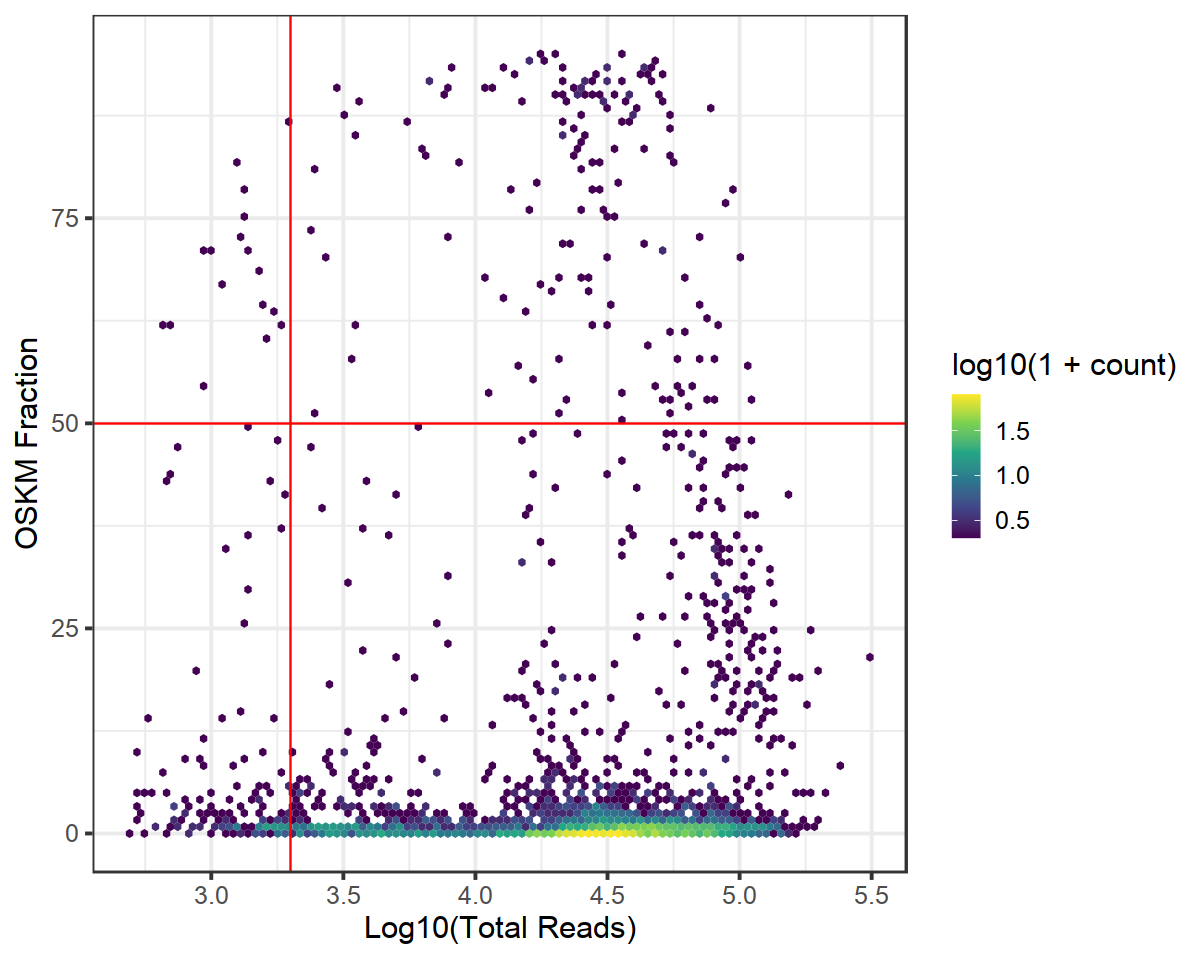

In [188]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(
    x=log10(rna$nCount_RNA[rna$sample=="D2"]),
    y=rna$percent.oskm[rna$sample=="D2"]), 
        "Log10(Total Reads)", 
        "OSKM Fraction",
       log10(2000), 50)

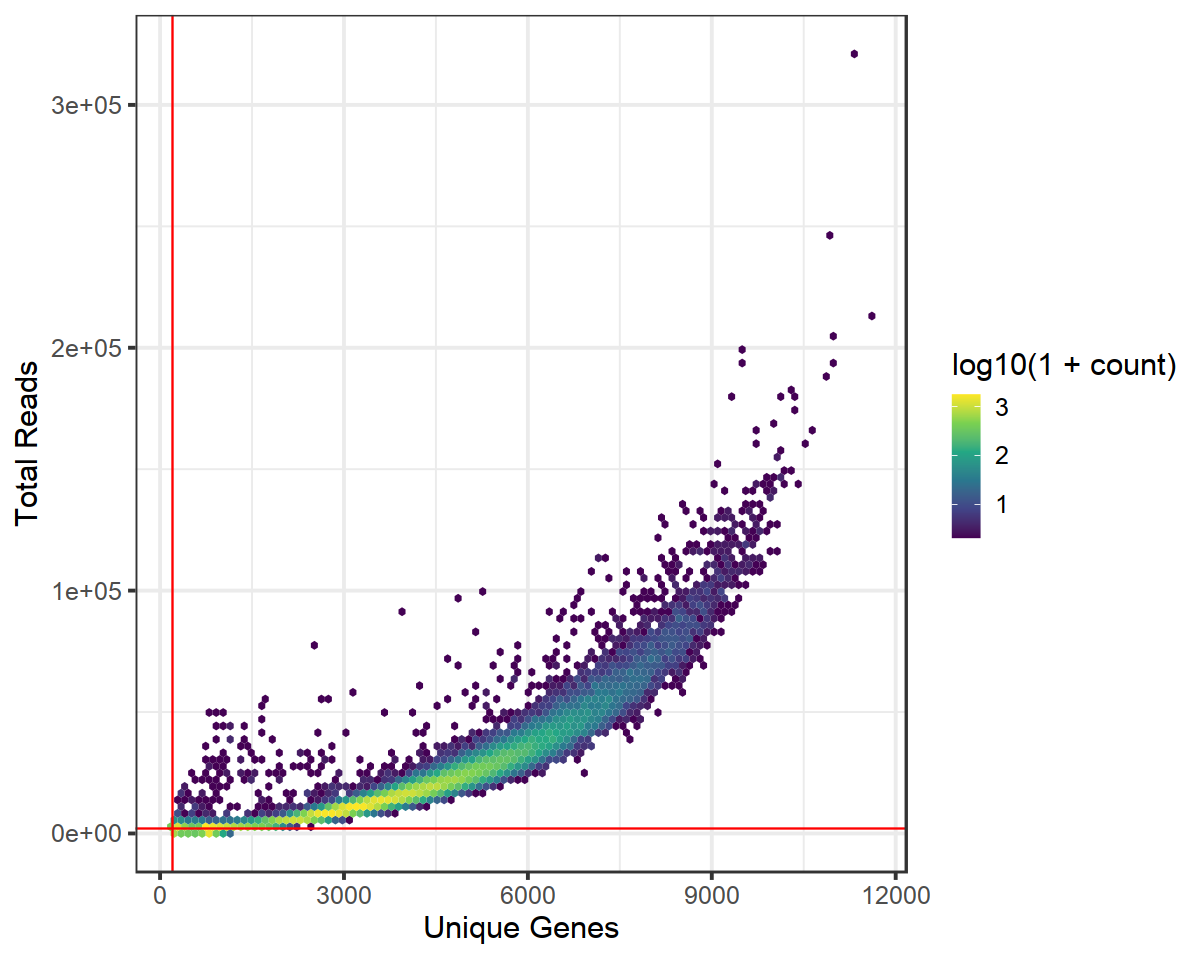

In [59]:
options(repr.plot.width = 10, repr.plot.height = 8)
qc_plot(data.frame(x=rna@meta.data$nFeature_RNA,
                   y=rna@meta.data$nCount_RNA),
        "Unique Genes", "Total Reads",
       200,2000)

In [23]:
head(rna@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample percent.mt
AAACCCAAGAGTGACC-1 scRNA-reprog 13707      3472         D0     4.238710  
AAACCCAAGTGCCAGA-1 scRNA-reprog 12326      3497         D0     5.719617  
AAACCCACAACTCGAT-1 scRNA-reprog 22321      4690         D0     4.784732  
AAACCCACACCATTCC-1 scRNA-reprog 14442      3996         D0     4.216867  
AAACCCACACGACAGA-1 scRNA-reprog 33141      5709         D0     4.547238  
AAACCCACACGCGTCA-1 scRNA-reprog  8813      2793         D0     4.788381  
                   percent.oskm
AAACCCAAGAGTGACC-1 0.007295542 
AAACCCAAGTGCCAGA-1 0.016225864 
AAACCCACAACTCGAT-1 0.008960172 
AAACCCACACCATTCC-1 0.013848497 
AAACCCACACGACAGA-1 0.009052231 
AAACCCACACGCGTCA-1 0.011346874

[1] 0.01095541

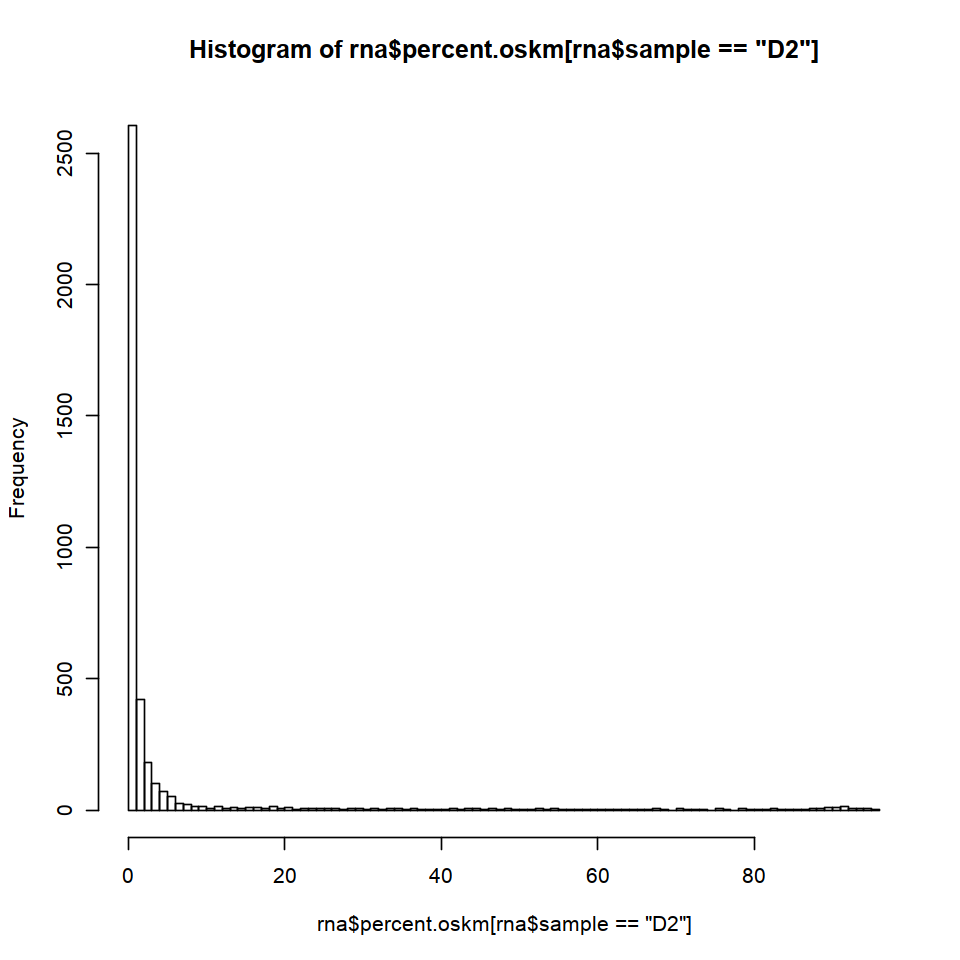

In [41]:
hist(rna$percent.oskm[rna$sample=="D2"], breaks=100)
mean(rna$percent.oskm[rna$sample=="D2"] > 50)

In [42]:
md = rna@meta.data
conds = md$nFeature_RNA > 200 & md$percent.mt <15 & md$percent.oskm <50 & md$nCount_RNA > 2000 & md$nCount_RNA < 1e5 
sum(conds)
table(md$sample[conds])

[1] 69858


   D0   D10   D12   D14    D2    D4    D6    D8  iPSC 
11481 12286  8464  8864  3094  6271  9218  6504  3676 

In [43]:
select_bool = rep(0, ncol(rna))
select_bool[conds] = 1
rna[['selected']]= select_bool

In [44]:
# rna_subset <- subset(rna, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10)
rna_subset = subset(rna, subset = selected==1)

In [84]:
table(rna_subset@meta.data$sample)


   D0   D10   D12   D14    D2    D4    D6    D8  iPSC 
11481 12286  8464  8864  3094  6271  9218  6504  3676 

## DoubletFinder

In [85]:
doublets = c()

# TODO: technically pK needs to be optimised per sample [need to code that in]
for (d in DAYS) {
    rna_sample = subset(rna_subset, subset = sample==d)
    
    rna_sample <- NormalizeData(rna_sample)
    rna_sample <- FindVariableFeatures(rna_sample, selection.method = "vst", nfeatures = 2000)
    all.genes <- rownames(rna_sample)
    rna_sample <- ScaleData(rna_sample, features = all.genes)
    rna_sample <- RunPCA(rna_sample, features = VariableFeatures(object = rna_sample))
    rna_sample <- RunUMAP(rna_sample, dims = 1:10)
    
    nExp_poi <- round(0.15*ncol(rna_sample)) # 15% stringent (?)
    rna_sample <- doubletFinder_v3(rna_sample, PCs = 1:10, pN = 0.25, pK = 0.01, nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)
    
    doublets = c(doublets, rownames(rna_sample@meta.data)[rna_sample@meta.data[, grep("DF.classifications", colnames(rna_sample@meta.data))[1]]=="Doublet"])
}

Centering and scaling data matrix

PC_ 1 
Positive:  FTH1, FTL, NUPR1, MFAP4, NEAT1, CLU, CEBPD, DCN, COL1A1, TGFBI 
	   COL3A1, JUNB, PTGDS, C1S, SOX4, MALAT1, GABARAP, APOE, ARID5B, SQSTM1 
	   SELENOM, RPS28, BMP4, RGS10, TKT, LXN, FBLN1, NBL1, ZFP36, AKR1C1 
Negative:  H2AFZ, CENPF, CKS1B, HMGB2, TYMS, MKI67, UBE2C, TOP2A, MAD2L1, BIRC5 
	   UBE2S, UBE2T, PRC1, PBK, RRM2, CCNB1, TUBB4B, TUBA1C, ZWINT, TUBA1B 
	   TPX2, CENPW, CKS2, SMC4, ASPM, CDC20, KIF20B, PTTG1, H2AFX, NUSAP1 
PC_ 2 
Positive:  CCNB1, CDC20, CENPA, ARL6IP1, CENPE, ASPM, CCNB2, PLK1, DLGAP5, CENPF 
	   NUF2, NDC80, NUSAP1, HMMR, TOP2A, NEK2, SOX4, CDCA3, PIMREG, DEPDC1 
	   KIF2C, TPX2, GTSE1, PRC1, HMGB2, MKI67, MXD3, PBK, KIF20A, KIF14 
Negative:  PHLDA2, CCND1, TNFRSF12A, TAGLN, SERPINE1, TPM1, SPARC, GAS6, HSPA5, COTL1 
	   SRM, C12orf75, SLC16A3, CALR, CAVIN1, SDF2L1, GLRX, IL7R, DCBLD2, RAB3B 
	   MGLL, CAV1, ZYX, UGCG, NME1, NABP1, SMURF2, NME2, RGCC, CSRP1 
PC_ 3 
Positive:  HMGA1, TUBA1B, CRABP2, PTMA, T

[1] "Creating 3827 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  MT2A, COL3A1, THY1, PHLDA1, NCL, CHN1, CD44, SMC4, CENPW, NR2F2 
	   HSPD1, FABP5, NOP56, NES, NR2F1, MAD2L1, TBX2, CLDN11, SRM, TPM1 
	   ARHGAP18, NT5E, SFRP1, F2R, CCNB1, CKS2, ZFP36L1, ANXA1, DCBLD2, BZW2 
Negative:  TNNT1, COL9A3, FBXO2, FSTL3, EEF1A2, PTP4A3, S100P, HBA1, HBA2, ARC 
	   TNNC1, CNFN, ASCL2, CALY, ADAM8, SCNN1D, KLK1, DMKN, PSTPIP1, SBSN 
	   SOX15, MKNK2, HES4, SLC6A8, RASGRP2, KISS1R, IL11, TNNI3, MLF1, SLC17A7 
PC_ 2 
Positive:  ODC1, UBE2S, CYCS, GTF2A2, HSPD1, HSPE1, MYC, HSP90AB1, DDX21, SRM 
	   FERMT1, BZW2, LYAR, GAL, RFK, TOMM40, GLUL, CALM1, TFB1M, SLC38A5 
	   DANCR, POU5F1, CENPX, FABP5, CENPW, NOP56, NIPA1, RRM2, PAWR, HNRNPAB 
Negative:  COL1A2, COL1A1, COL6A3, FN1, SPARC, CTHRC1, IFI6, IFITM3, TAGLN, LGALS3 
	   ZFP36L1, MYL9, MT2A, MYLK, DCN, TGFBI, FOS, C1R, ISG15, JUNB 
	   UBE2L6, ARID5B, IGFBP4, TMEM158, RND3, C1S, TBX2, DUSP1, CARD16, LGALS3BP 
PC_ 3 
Positive:  CSTB, LYPD2, KCNJ12, PTGES, P

[1] "Creating 1031 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  COL1A2, FN1, COL1A1, COL6A2, COL6A3, TGFBI, SPARC, CTHRC1, MYL9, ZFP36L1 
	   MT2A, TIMP1, TNC, TAGLN, IFITM3, PDGFRB, COL12A1, CD82, IFI6, LGALS3BP 
	   PTN, IER3, LOXL2, MFAP4, C1R, TMEM158, LTBP2, DKK3, C1S, HTRA1 
Negative:  GTF2A2, ODC1, CALB1, FERMT1, CYCS, ARGFX, MYC, LIM2, POU5F1, CALM1 
	   LYAR, MIR302CHG, MT-ND2, AHCY, DDX21, SEC11C, CKB, L1TD1, LINC02582, HSPE1 
	   PLAAT3, OCIAD2, CD24, DANCR, LPCAT3, CHPT1, YBX3, NOP10, KLF4, UBE2S 
PC_ 2 
Positive:  FBXO2, HBA2, HBA1, DMKN, FSTL3, S100P, SLURP2, TNNI3, CKM, CNFN 
	   SCNN1D, LY6D, COL9A3, CDH15, PSTPIP1, KISS1R, ABCA7, SBSN, BSG, ARC 
	   TRH, MAB21L4, COL11A2, COMP, SLC17A7, EEF1A2, CLIC3, EPS8L1, MUC2, KCNN4 
Negative:  RPS17, SNHG5, RPL23, ANXA1, HSPE1, DANCR, PARP1, TOMM5, SRM, RPL27A 
	   CALB1, ATP5MC1, MYC, AHCY, ARHGAP18, YBX3, NCL, RPL13A, THY1, ARGFX 
	   CHST2, L1TD1, TMEM160, CHPT1, LINC02582, PCDH10, MIR302CHG, BOLA3, NDUFAF8, RPL22L1 
PC_ 3 
Positive:  LY

[1] "Creating 2090 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  COL1A1, COL6A2, COL1A2, COL6A3, COL6A1, TGFBI, SPARC, TIMP1, FN1, CTHRC1 
	   COL3A1, IER3, CTSB, PDGFRB, COL18A1, FTL, ZFP36L1, CD82, EMILIN1, HLA-B 
	   IFI6, FBLN1, IFITM3, PXDN, OLFM2, PLAU, LOXL2, ISG15, STC1, BGN 
Negative:  CD24, CALB1, POU5F1, MIR302CHG, PLAAT3, LIM2, LINC02582, GSTP1, HSPD1, SLIRP 
	   PARP1, DPH6, SOX2, CD36, AHCY, L1TD1, MYC, CD70, RPS17, KRT8 
	   OLFML3, KRT18, RPL7, PYGB, MT1X, TUBB4A, LINC00678, CKB, ARGFX, CHST2 
PC_ 2 
Positive:  NEAT1, IGFBP5, IFI27, SCUBE2, C11orf96, SOX2, COL3A1, MIR302CHG, TNFAIP6, FOS 
	   EDIL3, C1S, NOVA1, C1R, LYPLAL1-DT, POU5F1, LINC00437, PCMTD1, APOE, LINC00678 
	   UNC5B-AS1, PIR, FIRRE, CCNO, ATP10D, DPH6, LEPR, CD36, CD24, ROBO1 
Negative:  CENPF, UBE2C, TOP2A, MKI67, CCNB1, BIRC5, CKS2, ASPM, HMGB2, TPX2 
	   CDK1, H2AFZ, CKS1B, CDC20, TUBA1B, NUSAP1, CCNA2, GTSE1, DLGAP5, PRC1 
	   KPNA2, PBK, CENPA, HMMR, SMC4, MAD2L1, CDKN3, PTTG1, HMGB1, CCNB2 
PC_ 3 
Positive:  PP

[1] "Creating 3073 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  COL1A1, TGFBI, COL1A2, COL3A1, HLA-B, FN1, TIMP1, STC1, SPARC, ID3 
	   IER3, CTHRC1, PLAU, ID1, TUBA1A, CD82, LOXL2, DCN, ISG15, IFI6 
	   IFITM3, HTRA1, WNT5A, TBX2, MMD, OLFM2, PRRX1, TMEM158, C1R, MT2A 
Negative:  POU5F1, CD24, CALB1, PLAAT3, LINC02582, SOX2, LIM2, L1TD1, TNFSF9, OLFML3 
	   KLF4, KRT8, CD70, PYGB, MIR302CHG, C19orf33, ARGFX, KRT18, GSTP1, MYC 
	   DPPA4, CHST2, FERMT1, AK4, ARMT1, PPP1R14A, TUBB4A, AHCY, LINC00678, CD36 
PC_ 2 
Positive:  C11orf96, AREG, MX1, IFI44L, DCN, C1S, ITM2B, IFIT1, PAPPA, FBXO32 
	   BST2, OAS1, RGS4, OLFM2, IL1R1, IFI35, C1R, IFITM1, IFIT3, PTGS2 
	   ISG15, IFITM3, NRG1, IFI27, IFI6, PCMTD1, TNFAIP6, STAT1, SAT1, BDKRB2 
Negative:  TNFRSF12A, UBE2C, HMGA1, C12orf75, HIST1H4C, TPX2, UBE2S, TOP2A, CKS2, PTTG1 
	   CENPF, MKI67, CDC20, NT5E, CYTOR, CCNB1, PRC1, KPNA2, AHNAK, SERPINE1 
	   CCND1, FABP5, TAGLN, CAV1, GTSE1, CDCA3, CAVIN1, HMGB2, KIF20B, KCNMA1 
PC_ 3 
Positive:  MAL, DSP, 

[1] "Creating 2168 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  MT1X, POU5F1, PPP1R14A, PLAAT3, MIR302CHG, L1TD1, LIM2, UTF1, AK4, MT1G 
	   GSTP1, C19orf33, TUBB4A, KRT8, CALB1, SPINT2, TTYH1, DPPA4, CKB, NANOG 
	   ARGFX, UPP1, SLIRP, PARP1, KRT18, CD70, NDUFAB1, PCAT14, ASRGL1, TNNT1 
Negative:  COL1A1, LGALS1, COL1A2, COL6A3, TPM2, B2M, SH3BGRL3, SPARC, FN1, TGFBI 
	   CTHRC1, COL6A2, CAV1, MYL9, TAGLN, CD59, TUBA1A, PHLDA2, TPM1, TSPO 
	   LRRC17, MARCKS, CALD1, COL3A1, COTL1, CTSB, TGFB1I1, COL6A1, CHN1, PXDN 
PC_ 2 
Positive:  HOXA5, PMP22, OCIAD2, RBP1, PI16, CRABP2, IGFBP5, MAP1B, RGS2, MYC 
	   GSN, DIO2, HOXA4, ANXA1, CNTN1, SNCG, FTL, S100A4, NRP2, DPYSL3 
	   AKR1C1, RPS2, S100A6, PLPPR5, PRSS3, HOXA3, RPLP0, SNTG1, NR1H4, AKR1C2 
Negative:  MX1, MT2A, LY6E, IFI6, MT1E, STMN1, IFITM3, MT1G, IFITM1, SPINT2 
	   TAGLN, RAB3B, IFI27, TDGF1, EPSTI1, GAS6, MGLL, MT1H, TUBB2A, FBP1 
	   INHBA, ISG15, IFI35, NLRP7, COL6A2, MYL9, OAS1, IFIT1, TTYH1, MT1F 
PC_ 3 
Positive:  CD36, NEAT1, LINC0

[1] "Creating 4095 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  B2M, COL1A2, LGALS1, COL1A1, TPM2, COL6A3, COL3A1, SPARC, FN1, CHN1 
	   EMILIN1, COL6A1, MMP2, TIMP1, CTHRC1, SH3BGRL3, MALAT1, CD99, COL6A2, TIMP2 
	   HLA-B, TGFBI, TSPO, COL5A2, COL12A1, PCOLCE, MFAP2, PDGFRB, CALD1, MFAP4 
Negative:  POU5F1, UTF1, MT1X, PLAAT3, DPPA4, LIM2, MT1G, ASRGL1, NANOG, ESRG 
	   HMGA1, AK4, SPINT2, L1TD1, PARP1, TOMM7, TUBB4A, TDGF1, TTYH1, SEMA6A 
	   MIR302CHG, GSTP1, SLIRP, UPP1, F11R, LNCPRESS1, NLRP7, NDUFAB1, TNNT1, ABHD12B 
PC_ 2 
Positive:  ANXA1, SFRP1, PCLAF, PMP22, SNTG1, PCDH9, AKR1C3, HOTAIRM1, RGS2, MYC 
	   CAVIN2, MOXD1, NFIA, SERTAD4, PBK, ID3, CYTL1, KRT18, PCLO, CNRIP1 
	   SVIP, PCDH7, THSD7A, CD70, DANCR, PTTG1, CENPF, NRP2, S100A4, GYPC 
Negative:  IFITM3, MX1, SAT1, IFITM1, IFI27, IFI6, LY6E, CD82, RGCC, BST2 
	   MMP11, ITGA1, APOE, SPON2, EPSTI1, UACA, COL5A1, NLRP7, TDGF1, TYMP 
	   MT1E, MT1H, MT1G, ISG15, GJA1, STAT1, CTHRC1, OAS1, COL6A2, NTM 
PC_ 3 
Positive:  CENPF, UBE2C,

[1] "Creating 2821 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  COL1A2, COL6A3, COL1A1, COL3A1, B2M, FN1, TIMP1, COL6A1, HLA-B, EMILIN1 
	   BGN, COL6A2, TPM2, SPARC, TGFBI, MFAP4, IGFBP7, MMP2, LGALS1, S100A6 
	   COL5A2, COL4A1, IER3, COL4A2, COL12A1, TSPO, CHN1, RARRES2, CTHRC1, TIMP3 
Negative:  POU5F1, UTF1, MT1X, MT1G, SPINT2, TDGF1, LIM2, UGP2, APOE, PLAAT3 
	   NLRP7, HSP90AA1, MT1H, SLIRP, ESRG, L1TD1, TUBB2B, SET, RPS17, EPCAM 
	   MT1F, TCEA1, TMEM160, TUBB4A, F11R, MYBL2, SEMA6A, ASRGL1, HSPE1, NUDT15 
PC_ 2 
Positive:  IFI6, APOE, MT1H, C11orf96, PDLIM1, TIMP3, NLRP7, MT1E, INHBA, RAMP1 
	   CD82, SPON2, CTHRC1, DPPA3, CEBPB, COL8A1, MT1G, IFI27, HOPX, ISLR 
	   MT2A, MMP11, LINC01356, IGFBP3, BST2, HES4, LUM, CYTOR, PHLDA2, NLRP2 
Negative:  PCDH9, GYPC, MAP1B, AP1S2, CAVIN2, AKR1C3, ANXA1, PCDH7, AKR1C1, CD70 
	   PCLAF, ROBO1, CCDC50, MYC, NFIA, SFRP1, FBN2, CALB1, AKR1C2, VIM 
	   MOXD1, IGFBP2, KCNE5, NOVA1, PON2, MEOX2, LEMD1, KRT8, SNTG1, CYTL1 
PC_ 3 
Positive:  HLA-DQB1, ARG

[1] "Creating 2955 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Centering and scaling data matrix

PC_ 1 
Positive:  EIF3A, MKI67, PRRC2C, AKAP12, TPX2, CENPF, MT-ND4, HSP90B1, MT-ND2, SMARCC1 
	   SMARCA5, DSP, CHD4, APLP2, BPTF, SET, HNRNPU, NCL, KHDRBS1, TPM3 
	   ZC3H13, YWHAZ, L1TD1, EZR, IGF2BP1, MT-CO1, MYH10, SFPQ, SPTBN1, ENAH 
Negative:  RPL39, TMSB4X, MIR302CHG, ANGPT2, HMGA2-AS1, FTL, SHANK2-AS1, RPS4X, PRDX1, CCDC26 
	   AL451123.1, TTN, C2orf88, RNF213-AS1, AL356113.1, GRIN2A, DNAJB13, MT1G, AC007682.1, PF4 
	   AC027288.1, LINC02036, AL691420.1, TRDN, AP002954.2, PGAM2, MYOCOS, C19orf33, AC253572.2, MIR133A1HG 
PC_ 2 
Positive:  PRDX1, FTL, LDHB, H2AFZ, CFL1, RPS4X, TUBA1B, ACTG1, LDHA, SNHG29 
	   ACTB, SLC25A5, PRDX6, NDUFB11, TUBB, MARCKSL1, UBB, RPL39, TUBA1C, CYCS 
	   EIF4EBP1, DYNLL1, HSP90AB1, KRT18, FABP5, NME1, PSMD7, CKB, JPT1, BEX3 
Negative:  MALAT1, SNHG14, KCNQ1OT1, WSB1, FTX, GRIN2A, NFIA, DST, PNISR, NEAT1 
	   AC007218.1, PIF1, ZNF208, AASS, ASPM, GOLGA4, HELLS, AUXG01000058.1, ZNF292, ZNF66 
	   SORBS2, MIAT, HCG18

[1] "Creating 1225 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


In [87]:
length(unique(doublets))

[1] 10480

In [88]:
head(doublets)

[1] "AAACCCACAACTCGAT-1" "AAACCCACACGACAGA-1" "AAACGAATCAGCGGAA-1"
[4] "AAAGGGCAGTTGCCTA-1" "AAAGGGCCACCTGAAT-1" "AAAGGGCCATACATCG-1"

In [ ]:
# sweep.res.sample <- paramSweep_v3(rna_sample, PCs = 1:10, sct = FALSE)
# sweep.stats.sample <- summarizeSweep(sweep.res.sample, GT = FALSE)
# bcmvn.sample <- find.pK(sweep.stats.sample)

## Viz

## With doublets

In [89]:
rna_w_doub = rna_subset
    
rna_w_doub <- NormalizeData(rna_w_doub)
rna_w_doub <- FindVariableFeatures(rna_w_doub, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(rna_w_doub)
rna_w_doub <- ScaleData(rna_w_doub, features = all.genes)
rna_w_doub <- RunPCA(rna_w_doub, features = VariableFeatures(object = rna_w_doub))
rna_w_doub <- RunUMAP(rna_w_doub, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  DPPA4, UTF1, L1TD1, SPINT2, PLAAT3, ESRG, TDGF1, NANOG, SEMA6A, TUBB2B 
	   GSTP1, AK4, LIM2, CD24, MT1G, F11R, POU5F1, EPCAM, MIR302CHG, ASRGL1 
	   TUBB4A, LINC00678, CXADR, MT1X, LNCPRESS1, MT1H, UGP2, TRIML2, TET1, FRAT2 
Negative:  LGALS1, TPM2, B2M, COL1A1, COL6A3, SH3BGRL3, COL1A2, TIMP1, COL6A2, S100A6 
	   FN1, COL6A1, COL3A1, LGALS3, CD59, TSPO, CAV1, CTHRC1, CD99, FTH1 
	   MYL9, HLA-B, SPARC, TGFBI, DKK3, COL12A1, JUNB, TMEM158, IER3, CD44 
PC_ 2 
Positive:  MYC, ANXA1, CD36, S100A16, KLF4, GSN, FERMT1, CALB1, CHST2, GTF2A2 
	   CHPT1, ODC1, CAVIN2, PLA2G7, MET, PCDH10, PI16, ARHGAP18, PCDH9, TOMM5 
	   S100A6, SRM, PYGB, RFK, SOX2, ALDH1A2, ARGFX, ABI3, PTHLH, LINC00437 
Negative:  APOE, FOXD3-AS1, LIN28A, DNMT3B, TERF1, CLDN6, CRABP1, SFRP2, AC009446.1, EPCAM 
	   CCND2, TSTD1, TDGF1, LINC00458, PHC1, GABRB3, VASH2, FTL, AP1M2, AC064802.1 
	   CDH1, CNTNAP2, WFDC2, SAT1, LIN28B, IFITM1, ZIC2, AL353747.4, RAB25, SLC2A3 


In [90]:
rna_w_doub

An object of class Seurat 
29165 features across 69858 samples within 1 assay 
Active assay: RNA (29165 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [91]:
rna_w_doub[['doublet']] = rownames(rna_w_doub@meta.data) %in% doublets

In [102]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 sample=rna_w_doub@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=.5) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [103]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 doub=rna_w_doub@meta.data$doublet)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_doub <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=doub), stroke=0, size=.5) +
theme_classic() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

In [109]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 mt=rna_w_doub@meta.data$percent.mt)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_mt <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(mt))) +
geom_point(stroke=0, size=.5) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [115]:
library(scales)

In [126]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 oskm=rna_w_doub$percent.oskm)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_oskm <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(oskm))) +
geom_point(stroke=0, size=.5) +
theme_classic() +
scale_color_viridis_c(limits=c(0,10), oob=squish) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

In [143]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_1,
                 pc2=data.frame(Embeddings(rna_w_doub, reduction='umap'))$UMAP_2,
                 reads=log10(rna_w_doub$nCount_RNA))
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_reads <- ggplot(plot_df, aes(x=pc1, y=pc2, col=as.numeric(reads))) +
geom_point(stroke=0, size=.5) +
theme_classic() +
scale_color_viridis_c() +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 

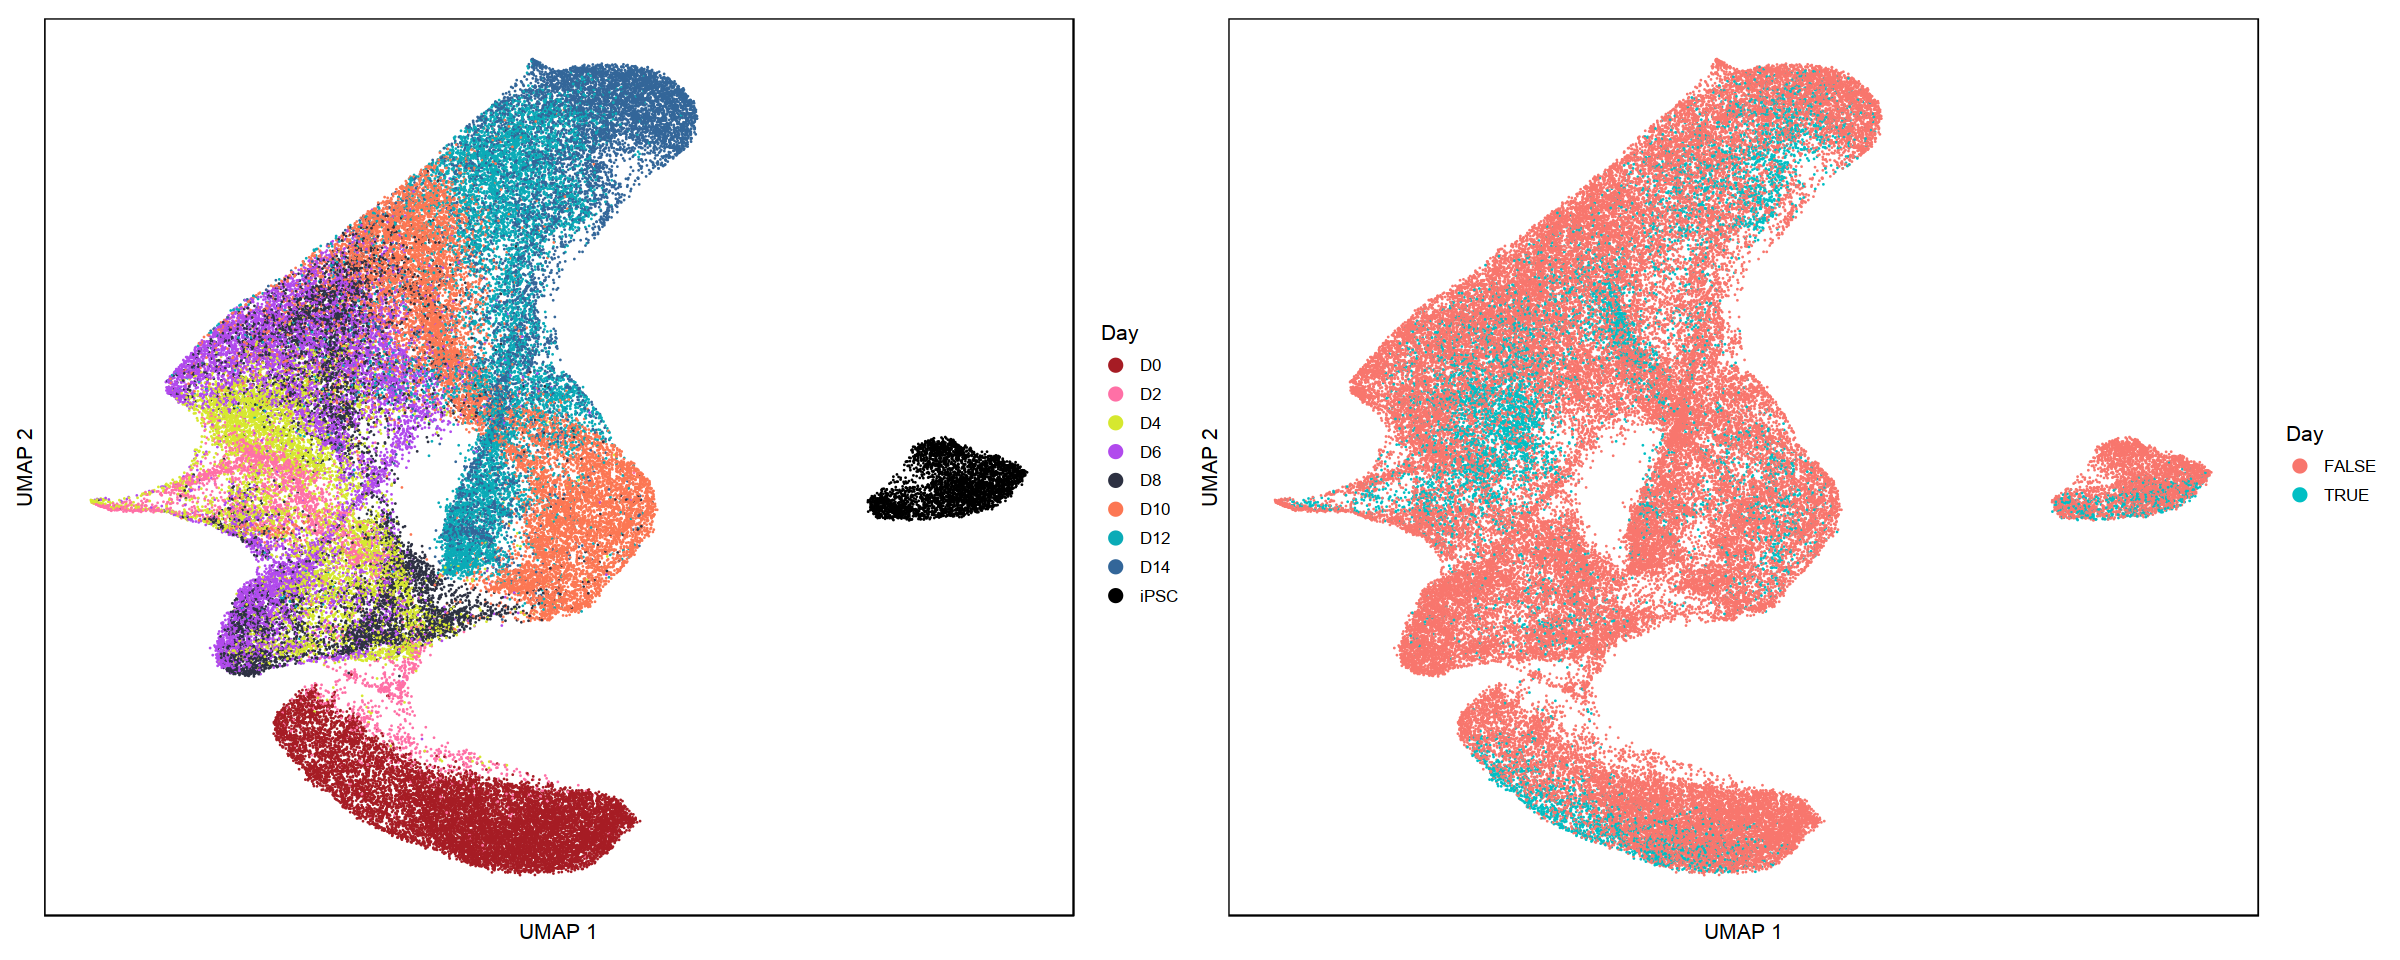

In [123]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_day | by_doub

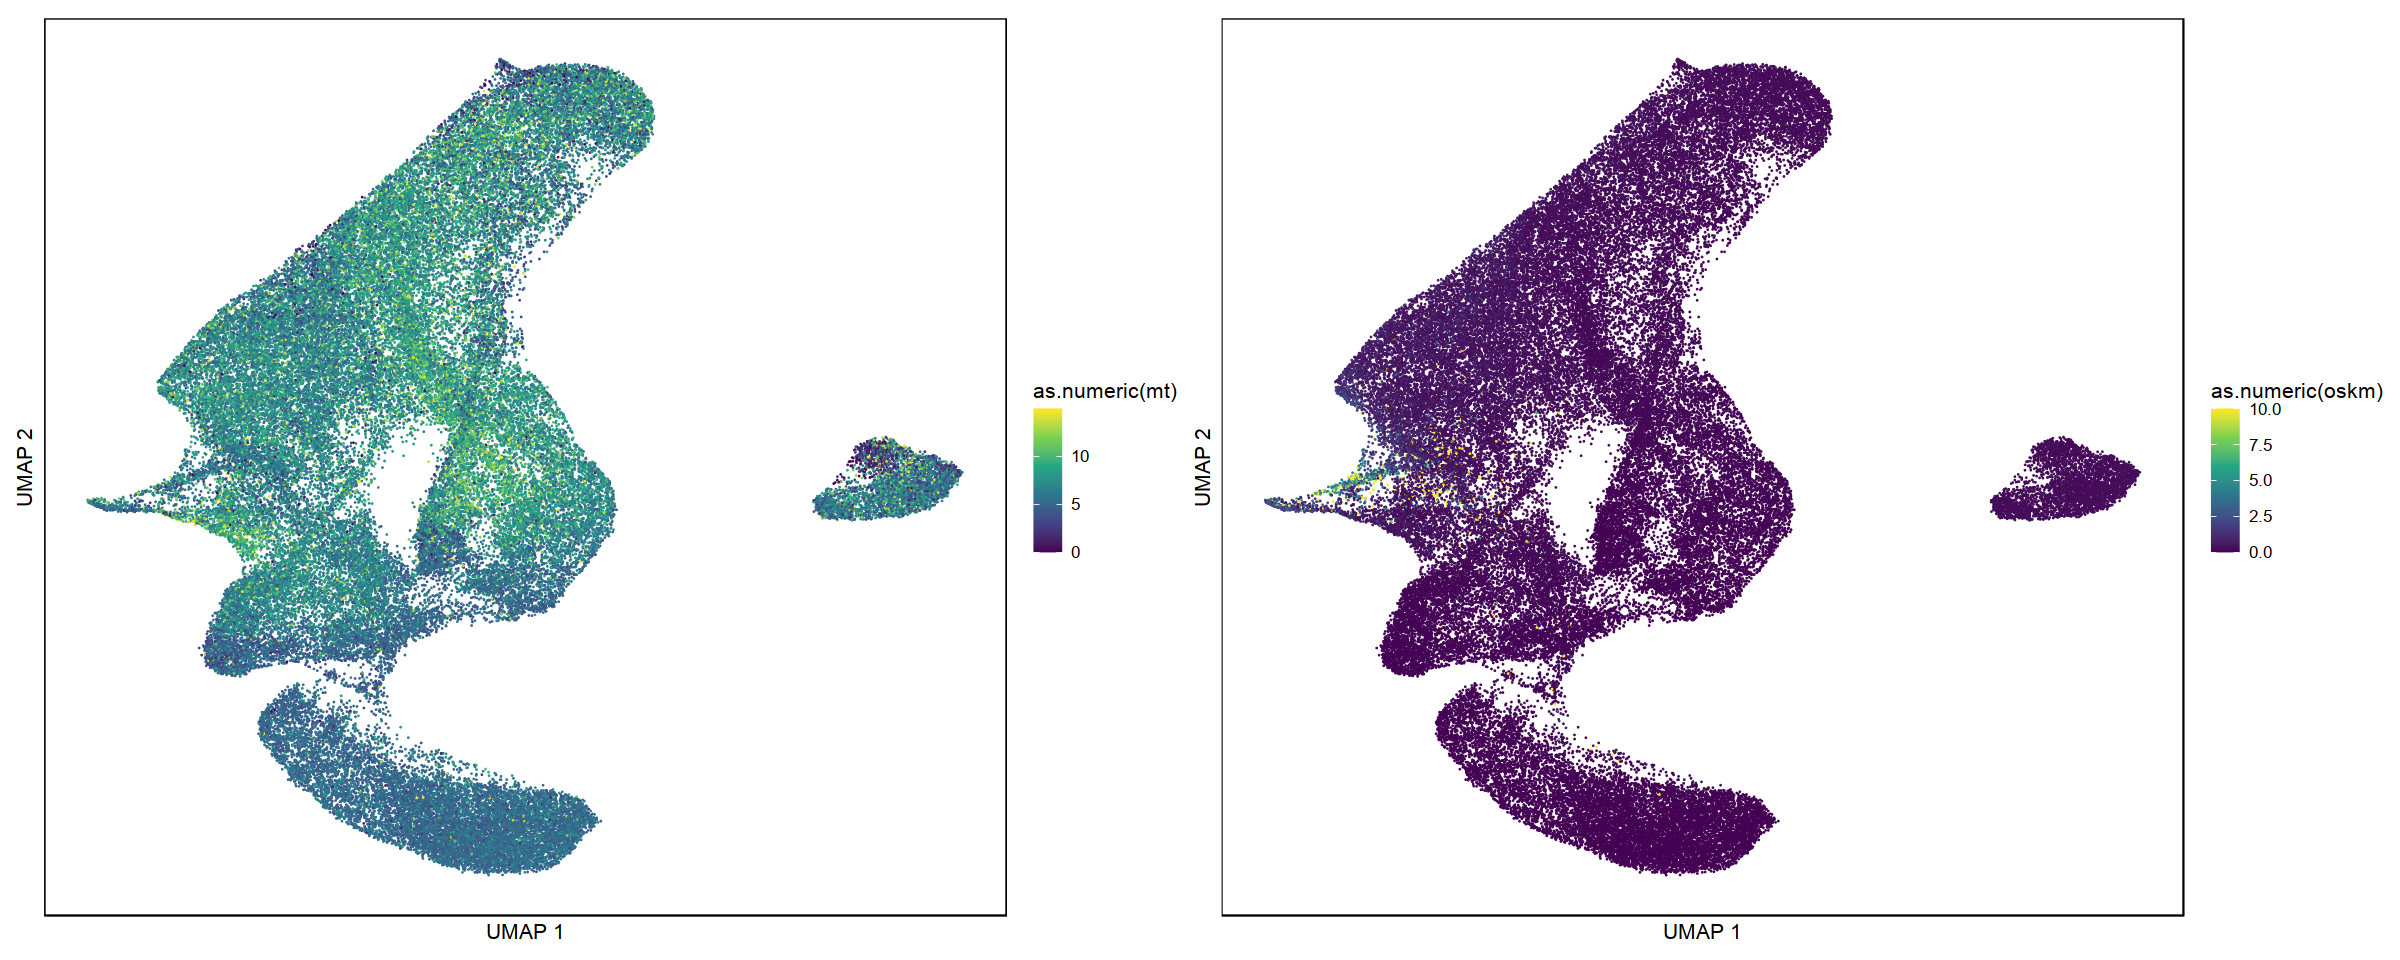

In [127]:
options(repr.plot.width = 20, repr.plot.height = 8)

by_mt | by_oskm

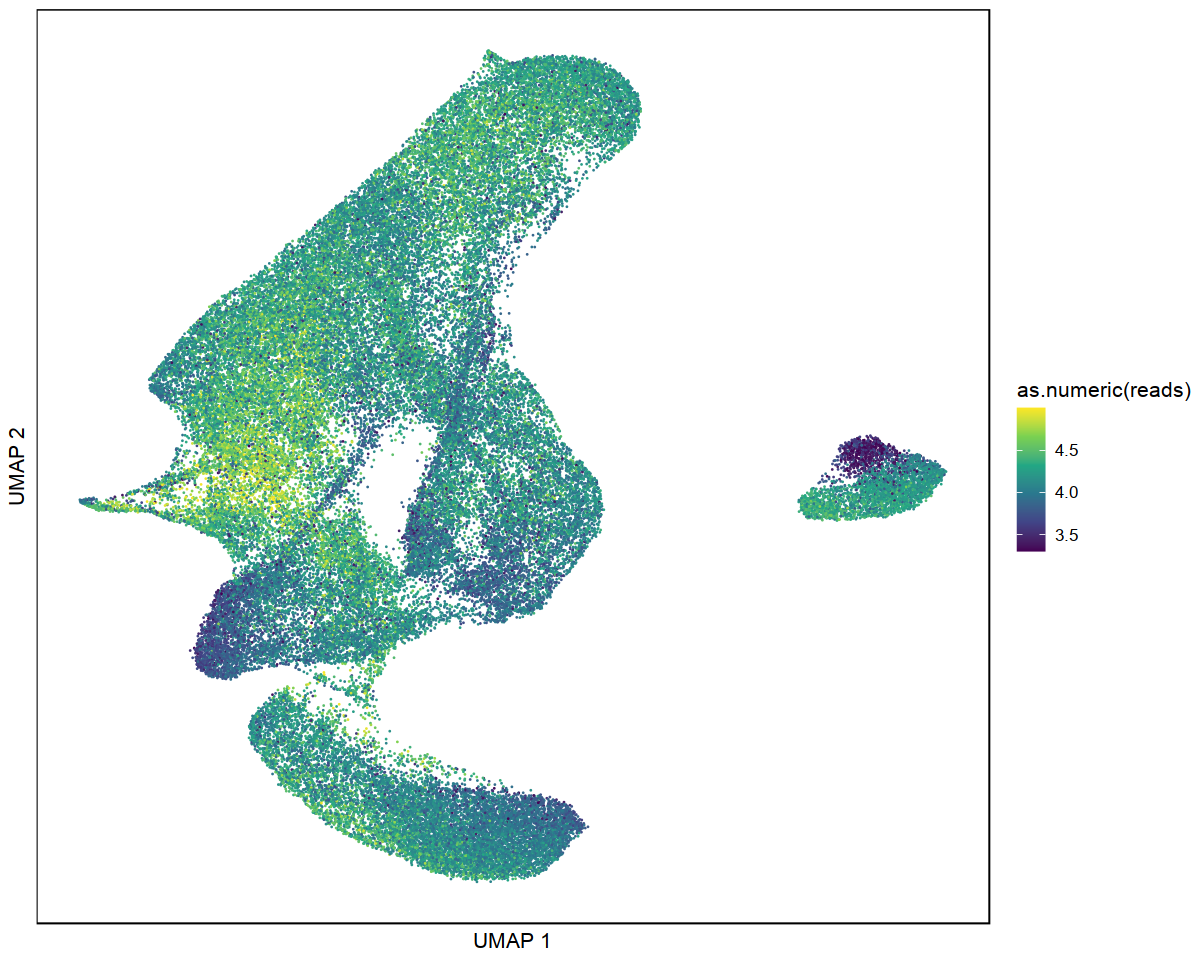

In [145]:
options(repr.plot.width = 10, repr.plot.height = 8)

by_reads

## Without doublets

In [135]:
rna_wo_doub = rna_subset
rna_wo_doub[['doublet']] = rownames(rna_wo_doub@meta.data) %in% doublets

rna_wo_doub = subset(rna_wo_doub, subset = doublet==F)

In [136]:
rna_wo_doub

An object of class Seurat 
29165 features across 59378 samples within 1 assay 
Active assay: RNA (29165 features, 0 variable features)

In [138]:
rna_wo_doub <- NormalizeData(rna_wo_doub)
rna_wo_doub <- FindVariableFeatures(rna_wo_doub, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(rna_wo_doub)
rna_wo_doub <- ScaleData(rna_wo_doub, features = all.genes)
rna_wo_doub <- RunPCA(rna_wo_doub, features = VariableFeatures(object = rna_wo_doub))
rna_wo_doub <- RunUMAP(rna_wo_doub, dims = 1:10)

Centering and scaling data matrix

PC_ 1 
Positive:  LGALS1, TPM2, COL1A1, B2M, COL6A3, COL1A2, SH3BGRL3, COL6A2, TIMP1, FN1 
	   COL6A1, COL3A1, CTHRC1, S100A6, LGALS3, TSPO, CAV1, SPARC, MYL9, HLA-B 
	   FTH1, CD99, TGFBI, IER3, COL12A1, DKK3, JUNB, TAGLN, TMEM158, IGFBP4 
Negative:  DPPA4, UTF1, L1TD1, PLAAT3, SPINT2, ESRG, NANOG, TDGF1, LIM2, SEMA6A 
	   POU5F1, CD24, GSTP1, MT1G, AK4, MIR302CHG, TUBB2B, F11R, TUBB4A, ASRGL1 
	   EPCAM, MT1X, LINC00678, MT1H, CXADR, LNCPRESS1, FRAT2, KRT18, LINC02582, TRIML2 
PC_ 2 
Positive:  MYC, ANXA1, S100A16, CD36, GSN, KLF4, ODC1, FERMT1, CHPT1, GTF2A2 
	   CALB1, NDUFAF8, CAVIN2, PLA2G7, S100A6, MET, ARHGAP18, CHST2, PCDH10, TOMM5 
	   PI16, SRM, PCDH9, LINC00437, SOX2, ALDH1A2, RFK, PTHLH, ABI3, SLC38A5 
Negative:  APOE, FOXD3-AS1, LIN28A, DNMT3B, TERF1, CLDN6, EPCAM, SFRP2, TDGF1, TSTD1 
	   CCND2, AC009446.1, CRABP1, SAT1, IFITM1, AC064802.1, PHC1, AP1M2, VASH2, CDH1 
	   JARID2, LINC00458, GABRB3, RAB25, ESRG, AC005062.1, LIN28B, AL35374

In [141]:
plot_df <- data.frame(pc1=data.frame(Embeddings(rna_wo_doub, reduction='umap'))$UMAP_1,
                 pc2= -data.frame(Embeddings(rna_wo_doub, reduction='umap'))$UMAP_2,
                 sample=rna_wo_doub@meta.data$sample)
plot_df = plot_df[sample(dim(plot_df)[1]), ]

by_day <- ggplot(plot_df) +
geom_point(aes(x=pc1, y=pc2, color=factor(sample, levels=DAYS)), stroke=0, size=0.5) +
theme_classic() +
scale_color_manual(values=day_config$colour) +
xlab("UMAP 1") + ylab("UMAP 2") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
guides(colour = guide_legend(title="Day",
     override.aes = list(shape=16, alpha=1, size=4)))

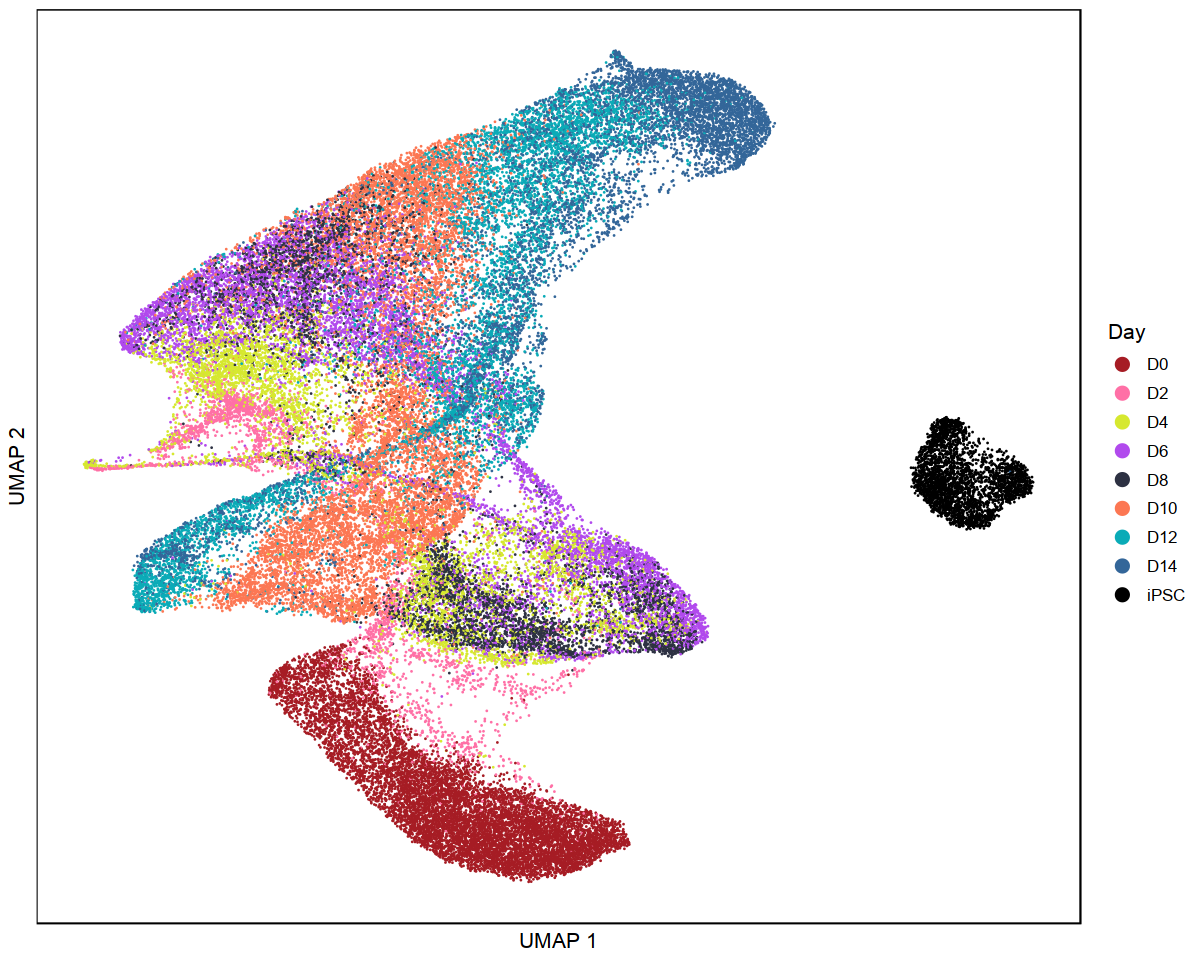

In [142]:
options(repr.plot.width = 10, repr.plot.height = 8)

by_day

In [156]:
# invert 
# rna_wo_doub@reductions$umap@cell.embeddings[,"UMAP_2"] = -rna_wo_doub@reductions$umap@cell.embeddings[,"UMAP_2"]

In [244]:
write.table(rownames(rna_wo_doub@meta.data),
            file='./barcodes/20210722_nFeat200_mt15_oskm50_nCount2000_doub15_pk0.01.txt',
            quote=F,
            row.names=F,
            col.names=F)

[[1]]


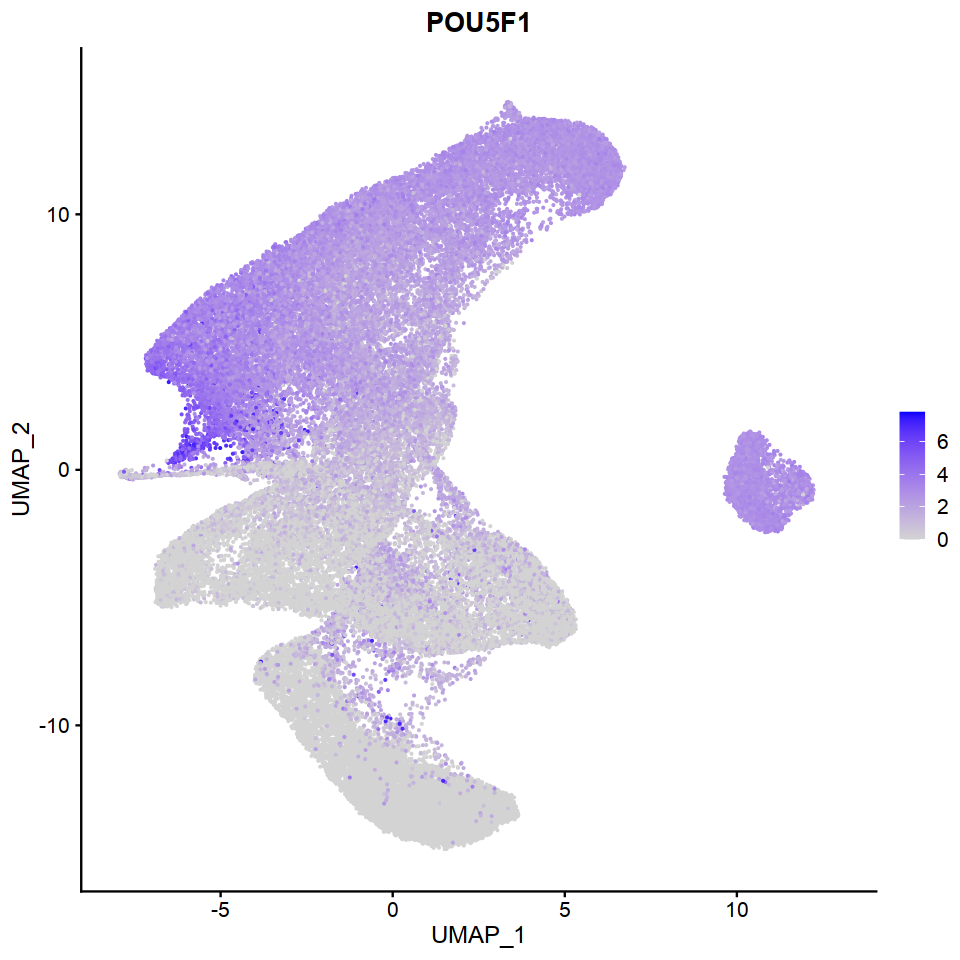

In [245]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna_wo_doub, features = c("POU5F1"), reduction = "umap", pt.size = 0.1, combine = FALSE)

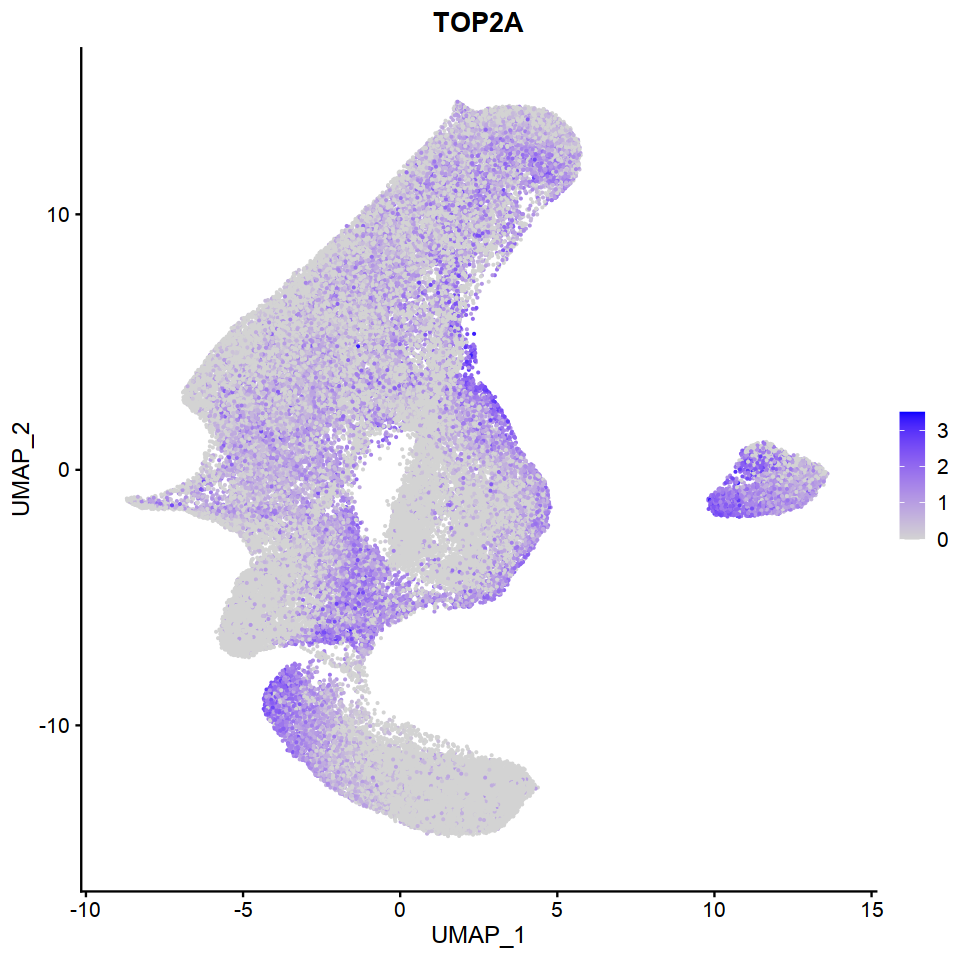

In [190]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna_w_doub, features = c("TOP2A"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]

---

In [249]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scales_1.1.0        KernSmooth_2.23-16  fields_10.3        
 [4] maps_3.3.0          spam_2.5-1          dotCall64_1.0-0    
 [7] DoubletFinder_2.0.3 patchwork_1.0.0     ggplot2_3.3.3      
[10] dplyr_1.0.2         Seurat_3.1.5       

loaded via a namespace (and not attached):
 